# Reading live data for prediction

To predict on real time it is needed to have online measurement.

Ayuntamiento de Madrid in its web (https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=41e01e007c9db410VgnVCM2000000c205a0aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default)
about AirQuality, provide measurements for all Air stations updated in real time, being the data updated every hour. This data update will happen between the minutes 20 and 30 of every hour.


**Disclaimer of live data: This data is live data automatically measured by the AirStations without any quality check, so data is pending to be reviewed and validated.**



In [30]:
#Libraries
#########

import requests
import numpy as np
import pandas as pd
import io
import time
import datetime
from datetime import timedelta
from datetime import datetime
import pickle

#Libraries for data visualization
#################################
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sbn
%matplotlib inline


#Libraries/functions for ARIMA modelling
#######################################
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
import statsmodels.api as sm

In [31]:

#Reading Air quality live data from online service from Ayuntamiento de Madrid web
##################################################################################

url = 'https://www.mambiente.madrid.es/opendata/horario.csv'

headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}

response = requests.get(url, headers=headers)
df_airlive = pd.read_csv(io.StringIO(response.text), sep=';')


In [32]:
df_airlive.head()

,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,V01,...,H20,V20,H21,V21,H22,V22,H23,V23,H24,V24
0,28,79,8,1,28079008_1_38,2021,12,27,3.0,V,...,0,N,0,N,0,N,0,N,0,N
1,28,79,8,6,28079008_6_48,2021,12,27,0.2,V,...,0,N,0,N,0,N,0,N,0,N
2,28,79,8,7,28079008_7_8,2021,12,27,5.0,V,...,0,N,0,N,0,N,0,N,0,N
3,28,79,8,8,28079008_8_8,2021,12,27,13.0,V,...,0,N,0,N,0,N,0,N,0,N
4,28,79,8,9,28079008_9_47,2021,12,27,2.0,V,...,0,N,0,N,0,N,0,N,0,N


Below code is the same code used in notebook 3. Cleaning_Transformation_Exploratory". This is used to transform the live data in the format needed to predict

In [33]:
#Transforming AirQuality_live data - 
#Code is explained in detail in the notebook "3.Cleaning Transformation Exploratory"
###############################################################################################################

df_airlive = df_airlive[(df_airlive['MAGNITUD'] == 8)]
df_airlive ['DATE'] = pd.to_datetime({'year': df_airlive['ANO'],
                                                          'month': df_airlive['MES'],
                                                          'day': df_airlive['DIA']})
df_airlive = pd.melt(df_airlive, id_vars=['ESTACION', 'MAGNITUD', 'PUNTO_MUESTREO','DATE'], value_vars=['H01', 'H02', 'H03', 'H04', 'H05',
                                                                                                'H06', 'H07', 'H08', 'H09', 'H10',
                                                                                                'H11', 'H12', 'H13', 'H14', 'H15',
                                                                                                'H16', 'H17', 'H18', 'H19', 'H20',
                                                                                                'H21', 'H22', 'H23', 'H24'])
df_airlive['HOUR'] = [int(x[1:3]) for x in df_airlive.variable.values]
df_airlive['TIME'] = df_airlive['DATE'].astype(str) + ' ' + (df_airlive['HOUR']-1).astype(str) + ':59:59'
df_airlive['TIME']=pd.to_datetime(df_airlive['TIME'] )
df_airlive.index = df_airlive.TIME
df_airlive.rename(columns={'value':'NO2_index'},inplace=True)
df_airlive.rename(columns={'ESTACION':'AirStationId'},inplace=True)
df_airlive.drop(['variable'], axis = 'columns', inplace=True)
df_airlive.drop(['MAGNITUD'], axis = 'columns', inplace=True)
df_airlive.drop(['PUNTO_MUESTREO'], axis = 'columns', inplace=True)
df_airlive.index = df_airlive.TIME
df_airlive = df_airlive[["AirStationId","NO2_index"]]


In [34]:
df_airlive.head()

,AirStationId,NO2_index
TIME,,
2021-12-27 00:59:59,8,13.0
2021-12-27 00:59:59,11,8.0
2021-12-27 00:59:59,16,11.0
2021-12-27 00:59:59,17,9.0
2021-12-27 00:59:59,18,7.0


As live data served by Ayuntamiento de Madrid is a file including the (only) 24hour of the current day, keeping as NaN data hours not register yet, for a better organization of the data, the dataframe with live data is cut, just keeping only the data with measurements,  considering the lag of 1 hour between every data publication

In [35]:
#Adding a lag time from live data to remove the lag between current time and last refreshed data
##############################################################################

lag=str(datetime.now()-timedelta(hours=1))
df=df_airlive.loc[:lag]

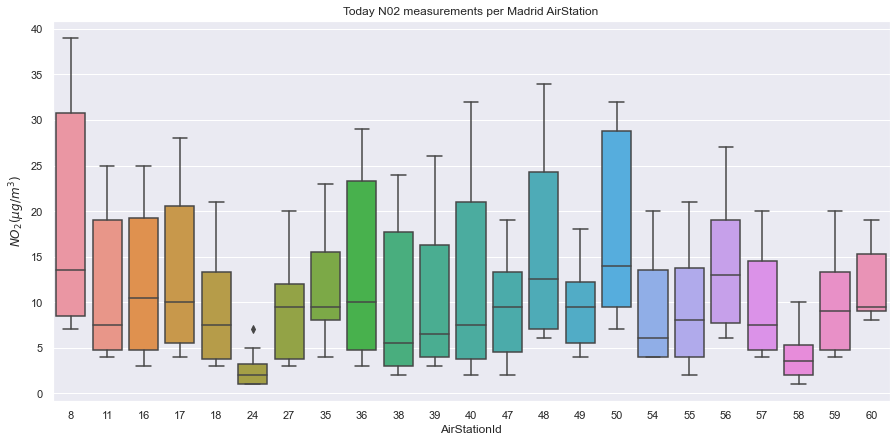

In [36]:
# N02 distribution per AirStation on live data
#############################################

sbn.set(rc={'figure.figsize':(15, 7)})
sbn.boxplot(data=df, x='AirStationId', y='NO2_index').set(title="Today N02 measurements per Madrid AirStation", ylabel='$NO_2 (µg/m^3)$');

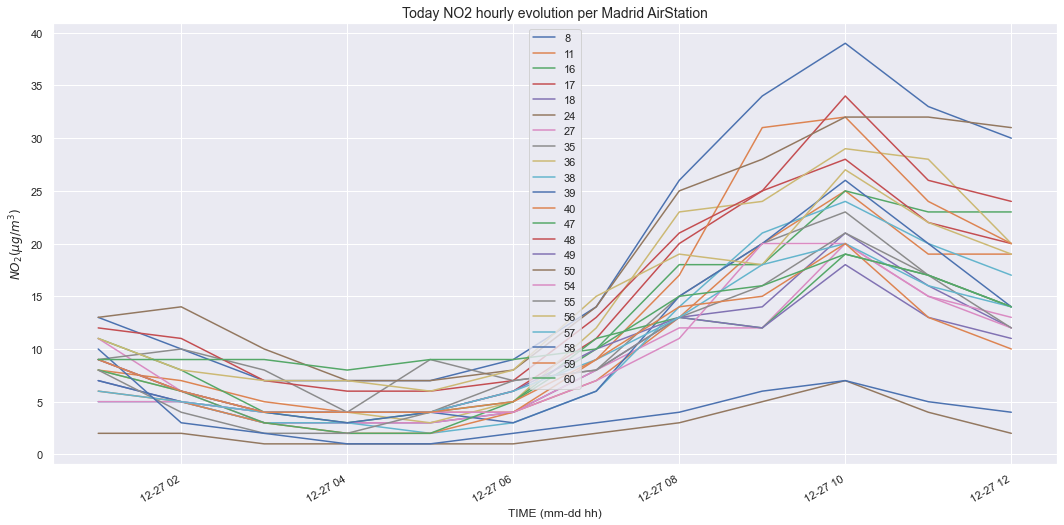

In [37]:
#Plotting NO2 hourly evolution per AirStation
############################################


fig, ax = plt.subplots(figsize=(18,9))

df.groupby("AirStationId")['NO2_index'].plot(ax=ax);

plt.ylabel("$NO_2 (µg/m^3)$")
plt.xlabel("TIME (mm-dd hh)")
plt.title("Today NO2 hourly evolution per Madrid AirStation",fontsize=14);
plt.legend();

Adding historical data (same data used for train the model) and trasforming using the same code used in notebook 3. Cleaning_Transformation_Exploratory". This will be concatenated to live data to improve prediction model performance

In [38]:
#Reading dataframe with all historical data for AirQuality.
####################################################################

df_airhis = pd.read_csv ("../data/interim/AirQuality/ref_air_quality.csv", sep= ',')


#Transforming AirQuality_historical data - 
#Code is explained in detail in the notebook "3.Cleaning Transformation Exploratory"
###############################################################################################################



df_airhis = df_airhis[(df_airhis['MAGNITUD'] == 8)]
df_airhis ['DATE'] = pd.to_datetime({'year': df_airhis['ANO'],
                                                          'month': df_airhis['MES'],
                                                          'day': df_airhis['DIA']})
df_airhis = pd.melt(df_airhis, id_vars=['ESTACION', 'MAGNITUD', 'PUNTO_MUESTREO','DATE'], value_vars=['H01', 'H02', 'H03', 'H04', 'H05',
                                                                                                'H06', 'H07', 'H08', 'H09', 'H10',
                                                                                                'H11', 'H12', 'H13', 'H14', 'H15',
                                                                                                'H16', 'H17', 'H18', 'H19', 'H20',
                                                                                                'H21', 'H22', 'H23', 'H24'])
df_airhis['HOUR'] = [int(x[1:3]) for x in df_airhis.variable.values]
df_airhis['TIME'] = df_airhis['DATE'].astype(str) + ' ' + (df_airhis['HOUR']-1).astype(str) + ':59:59'
df_airhis['TIME']=pd.to_datetime(df_airhis['TIME'] )
df_airhis.index = df_airhis.TIME
df_airhis.rename(columns={'value':'NO2_index'},inplace=True)
df_airhis.rename(columns={'ESTACION':'AirStationId'},inplace=True)
df_airhis.drop(['variable'], axis = 'columns', inplace=True)
df_airhis.drop(['MAGNITUD'], axis = 'columns', inplace=True)
df_airhis.drop(['PUNTO_MUESTREO'], axis = 'columns', inplace=True)
df_airhis.index = df_airhis.TIME
df_airhis = df_airhis[["AirStationId","NO2_index"]]

**Preparing dataframe with live data for prediction**



In [39]:
#Breakingdown the dataframe with all AirStation per AirStation for prediction
#############################################################################

as_groups = df.groupby(df.AirStationId)


try:
    df_4 = as_groups.get_group(4)
except:
    df_4 = None
    
try:    
    df_8 = as_groups.get_group(8)
except:  
    df_8 = None 
    
try:
    df_11 = as_groups.get_group(11)
except:
    df_11 = None
    
try:
    df_16 = as_groups.get_group(16)
except:
    df_16 = None
    
try:   
    df_17 = as_groups.get_group(17)
except:    
    df_17 = None
    
try:
    df_18 = as_groups.get_group(18)
except:    
    df_18 = None
    
try:
    df_24 = as_groups.get_group(24)
except:   
    df_24 = None
    
try:
    df_27 = as_groups.get_group(27)
except:  
    df_27 = None
    
try:
    df_35 = as_groups.get_group(35)
except:   
    df_35 = None
    
try:
    df_36 = as_groups.get_group(36)
except:   
    df_36 = None
    
try:
    df_38 = as_groups.get_group(38)
except:    
    df_38 = None
    
try:
    df_39 = as_groups.get_group(39)
except:   
    df_39 = None
    
try:
    df_40 = as_groups.get_group(40)
except:    
    df_40 = None
    
try:
    df_47 = as_groups.get_group(47)
except:   
    df_47 = None
    
try:
    df_48 = as_groups.get_group(48)
except:  
    df_48 = None
    
try:
    df_49 = as_groups.get_group(49)
except:    
    df_49 = None
    
try:
    df_50 = as_groups.get_group(50)
except:    
    df_50=None
    
try:
    df_54 = as_groups.get_group(54)
except:    
    df_54=None
    
try:
    df_55 = as_groups.get_group(55)
except: 
    df_55 = None
    
try:
    df_56 = as_groups.get_group(56)
except:    
    df_56 = None
    
try:
    df_57 = as_groups.get_group(57)
except:    
    df_57 = None
    
try:
    df_58 = as_groups.get_group(58)
except:    
    df_58 = None
    
try:
    df_59 = as_groups.get_group(59)
except:   
    df_59 = None

try:
    df_60 = as_groups.get_group(60)
except:
    df_60 = None

Due to sometimes not all AirStations provide data any time due to communication problems or others issue, above script create a separate dataframe per station, even for the ones with no data, just to be sure that code works although not all data is available in any time.

To these dataframes, 24 empty (with NaN values) Rows have been added to allocate the different predicted values.

In [40]:
df_60

,AirStationId,NO2_index
TIME,,
2021-12-27 00:59:59,60,9.0
2021-12-27 01:59:59,60,9.0
2021-12-27 02:59:59,60,9.0
2021-12-27 03:59:59,60,8.0
2021-12-27 04:59:59,60,9.0
2021-12-27 05:59:59,60,9.0
2021-12-27 06:59:59,60,10.0
2021-12-27 07:59:59,60,15.0
2021-12-27 08:59:59,60,16.0


In [12]:
#Current time variables to identify the amount of rows to be added in the different dataframes for every station
###############################################################################################################
now=datetime.now()
now_minutes=('%02d:%02d.%d'%(now.minute,now.second,now.microsecond))[:-4]

#Adding 24 rows for prediction with time index 1hour and 1 second less to avoid duplicate time index
#in case current minute time is  <30 minutes avoiding duplicate time index
####################################################################################################
if now_minutes < "30:00.00":
    time2pred = pd.to_datetime(lag)
    time2pred = time2pred.round(freq='H')
    time2pred = time2pred + timedelta(seconds=3599)
    if df_4 is not None:
        df_4 = pd.concat([df_4, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_4=df_4[['NO2_index']]
    if df_8 is not None:   
        df_8 = pd.concat([df_8, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_8=df_8[['NO2_index']]
    if df_11 is not None:    
        df_11 = pd.concat([df_11, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_11=df_11[['NO2_index']]
    if df_16 is not None:    
        df_16 = pd.concat([df_16, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_16=df_16[['NO2_index']]
    if df_17 is not None:    
        df_17 = pd.concat([df_17, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_17=df_17[['NO2_index']]
    if df_18 is not None:     
        df_18 = pd.concat([df_18, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_18=df_18[['NO2_index']]
    if df_24 is not None:     
        df_24 = pd.concat([df_24, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_24=df_24[['NO2_index']]
    if df_27 is not None:       
        df_27 = pd.concat([df_27, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_27=df_27[['NO2_index']]
    if df_35 is not None:    
        df_35 = pd.concat([df_35, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_35=df_35[['NO2_index']]
    if df_36 is not None:     
        df_36 = pd.concat([df_36, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_36=df_36[['NO2_index']]
    if df_38 is not None:     
        df_38 = pd.concat([df_38, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_38=df_38[['NO2_index']]
    if df_39 is not None:     
        df_39 = pd.concat([df_39, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_39=df_39[['NO2_index']]
    if df_40 is not None:     
        df_40 = pd.concat([df_40, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_40=df_40[['NO2_index']]
    if df_47 is not None:     
        df_47 = pd.concat([df_47, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_47=df_47[['NO2_index']]
    if df_48 is not None:     
        df_48 = pd.concat([df_48, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_48=df_48[['NO2_index']]
    if df_49 is not None:      
        df_49 = pd.concat([df_49, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_49=df_49[['NO2_index']]
    if df_50 is not None:     
        df_50 = pd.concat([df_50, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_50=df_50[['NO2_index']]
    if df_54 is not None:       
        df_54 = pd.concat([df_54, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_54=df_54[['NO2_index']]
    if df_55 is not None:     
        df_55 = pd.concat([df_55, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_55=df_55[['NO2_index']]
    if df_56 is not None:     
        df_56 = pd.concat([df_56, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_56=df_56[['NO2_index']]
    if df_57 is not None:      
        df_57 = pd.concat([df_57, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_57=df_57[['NO2_index']]
    if df_58 is not None:   
        df_58 = pd.concat([df_58, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_58=df_58[['NO2_index']]
    if df_59 is not None:      
        df_59 = pd.concat([df_59, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_59=df_59[['NO2_index']]
    if df_60 is not None:     
        df_60 = pd.concat([df_60, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_60=df_60[['NO2_index']]
    

#Adding rows with time index 1 second less than current time for prediction
#in case current minute time is  >30 minutes avoiding duplicate time index
##########################################################################
if now_minutes > "30:00.00":
    time2pred = pd.to_datetime(lag)
    time2pred = time2pred.round(freq='H')
    time2pred = time2pred - timedelta(seconds=1)


    if df_4 is not None:
        df_4 = pd.concat([df_4, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_4=df_4[['NO2_index']]
    if df_8 is not None:   
        df_8 = pd.concat([df_8, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_8=df_8[['NO2_index']]
    if df_11 is not None:    
        df_11 = pd.concat([df_11, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_11=df_11[['NO2_index']]
    if df_16 is not None:    
        df_16 = pd.concat([df_16, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_16=df_16[['NO2_index']]
    if df_17 is not None:    
        df_17 = pd.concat([df_17, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_17=df_17[['NO2_index']]
    if df_18 is not None:     
        df_18 = pd.concat([df_18, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_18=df_18[['NO2_index']]
    if df_24 is not None:     
        df_24 = pd.concat([df_24, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_24=df_24[['NO2_index']]
    if df_27 is not None:       
        df_27 = pd.concat([df_27, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_27=df_27[['NO2_index']]
    if df_35 is not None:    
        df_35 = pd.concat([df_35, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_35p=df_35[['NO2_index']]
    if df_36 is not None:     
        df_36 = pd.concat([df_36, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_36=df_36[['NO2_index']]
    if df_38 is not None:     
        df_38 = pd.concat([df_38, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_38=df_38[['NO2_index']]
    if df_39 is not None:     
        df_39 = pd.concat([df_39, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_39=df_39[['NO2_index']]
    if df_40 is not None:     
        df_40 = pd.concat([df_40, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_40=df_40[['NO2_index']]
    if df_47 is not None:     
        df_47 = pd.concat([df_47, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_47=df_47[['NO2_index']]
    if df_48 is not None:     
        df_48 = pd.concat([df_48, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_48p=df_48[['NO2_index']]
    if df_49 is not None:      
        df_49 = pd.concat([df_49, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_49=df_49[['NO2_index']]
    if df_50 is not None:     
        df_50 = pd.concat([df_50, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_50=df_50[['NO2_index']]
    if df_54 is not None:       
        df_54 = pd.concat([df_54, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_54=df_54[['NO2_index']]
    if df_55 is not None:     
        df_55 = pd.concat([df_55, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_55=df_55[['NO2_index']]
    if df_56 is not None:     
        df_56 = pd.concat([df_56, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_56=df_56[['NO2_index']]
    if df_57 is not None:      
        df_57 = pd.concat([df_57, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_57=df_57[['NO2_index']]
    if df_58 is not None:   
        df_58 = pd.concat([df_58, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_58=df_58[['NO2_index']]
    if df_59 is not None:      
        df_59 = pd.concat([df_59, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_59=df_59[['NO2_index']]
    if df_60 is not None:     
        df_60 = pd.concat([df_60, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
        df_60=df_60[['NO2_index']]

In [13]:
df_60p

,NO2_index
2021-12-27 00:59:59,9.0
2021-12-27 01:59:59,9.0
2021-12-27 02:59:59,9.0
2021-12-27 03:59:59,8.0
2021-12-27 04:59:59,9.0
2021-12-27 05:59:59,9.0
2021-12-27 06:59:59,10.0
2021-12-27 07:59:59,15.0
2021-12-27 08:59:59,NaN
2021-12-27 09:59:59,NaN


**Load the model**

To load a saved model, all you need to do is pass the “pickled” model into the Pickle load() function and it will be deserialized. By assigning this back to a model object, you can then run your original model’s predict() function, pass in some test data and get back an array of predictions.

In [14]:
#Loading the model previously designed in notebook 4.Modelling SARIMA poc16
###########################################################################

pickled_model = pickle.load(open('../models/poc_16_SARIMAmodel_301_311_12.pkl', 'rb'))

Populating the prediction using 24 hour dynamic window. This is populated in a new field "Forecast".

In [15]:
#Predicting 24 hours ahead
##########################


modelB = sm.tsa.SARIMAX(df_16, order=(3,0,1),
                                seasonal_order=(3,1,1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
resB = modelB.smooth(pickled_model.params)



pred = resB.predict(start = df_16.index[len(df_16)-26], end=df_16.index[len(df_16)-1], dynamic=True)
df_16['Forecast'] = pred
    


/Users/cortinas/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/Users/cortinas/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


In [16]:
df_16

,NO2_index,Forecast
2021-12-27 00:59:59,11.0,NaN
2021-12-27 01:59:59,8.0,NaN
2021-12-27 02:59:59,4.0,NaN
2021-12-27 03:59:59,3.0,NaN
2021-12-27 04:59:59,4.0,NaN
2021-12-27 05:59:59,5.0,NaN
2021-12-27 06:59:59,10.0,NaN
2021-12-27 07:59:59,18.0,11.059133
2021-12-27 08:59:59,NaN,12.684290
2021-12-27 09:59:59,NaN,13.776730


In [18]:
#Function to prepare Airstation dataframes for streamlit frontend
#################################################################
def live(df):
    df['Source'] = df.apply(lambda x: 'Prediction' if np.isnan(x['NO2_index']) else 'Measurement', axis=1)
    df['NO2_index'] = [ df.Forecast.values[i] if np.isnan(df.NO2_index.values[i]) else df.NO2_index.values[i] for i in range(len(df))]
    

In [24]:
live(df_16p)
df_16p.head(20)

,NO2_index,Forecast,Source
2021-12-27 00:59:59,11.000000,NaN,Measurement
2021-12-27 01:59:59,8.000000,NaN,Measurement
2021-12-27 02:59:59,4.000000,NaN,Measurement
2021-12-27 03:59:59,3.000000,NaN,Measurement
2021-12-27 04:59:59,4.000000,NaN,Measurement
2021-12-27 05:59:59,5.000000,NaN,Measurement
2021-12-27 06:59:59,10.000000,NaN,Measurement
2021-12-27 07:59:59,18.000000,11.059133,Measurement
2021-12-27 08:59:59,12.684290,12.684290,Measurement
2021-12-27 09:59:59,13.776730,13.776730,Measurement


In [ ]:
df=[['NO2_index', 'Source']]

In [25]:
#Function to predict in all AirStations
#######################################

def livedata(df):
    #Error prone, conditional to avoid that an Airstation without live data can stop the script with an error
    if df is not None:
    
        #Prediction
        modelB = sm.tsa.SARIMAX(df, order=(3,0,1),
                                    seasonal_order=(3,1,1,12),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
        resB = modelB.smooth(pickled_model.params)
        pred = resB.predict(start = df.index[len(df)-26], end=df.index[len(df)-1], dynamic=True)
        df['Forecast'] = pred

        #Preparing dataframe for frontend in streamlit-folium representation
        df['Source'] = df.apply(lambda x: 'Prediction' if np.isnan(x['NO2_index']) else 'Measurement', axis=1)
        df['NO2_index'] = [ df.Forecast.values[i] if np.isnan(df.NO2_index.values[i]) else df.NO2_index.values[i] for i in range(len(df))]


In [27]:
livedata(df_4p)

/Users/cortinas/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/Users/cortinas/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


In [28]:
df_18p

,NO2_index,Forecast,Source
2021-12-27 00:59:59,7.000000,NaN,Measurement
2021-12-27 01:59:59,5.000000,NaN,Measurement
2021-12-27 02:59:59,3.000000,NaN,Measurement
2021-12-27 03:59:59,3.000000,NaN,Measurement
2021-12-27 04:59:59,3.000000,NaN,Measurement
2021-12-27 05:59:59,4.000000,NaN,Measurement
2021-12-27 06:59:59,8.000000,NaN,Measurement
2021-12-27 07:59:59,13.000000,8.808787,Measurement
2021-12-27 08:59:59,10.088522,10.088522,Prediction
2021-12-27 09:59:59,10.948424,10.948424,Prediction


In [182]:
#Organizing all AirStation dataframes for the frontend in streamlit
###################################################################

df_60p['Source'] = df_60p.apply(lambda x: 'Prediction' if np.isnan(x['NO2_index']) else 'Measurement', axis=1)
df_60p['NO2_index'] = [ df_60p.Forecast.values[i] if np.isnan(df_60p.NO2_index.values[i]) else df_60p.NO2_index.values[i] for i in range(len(df_60p))]

In [139]:
df_60p=df_60p[['NO2_index', 'Source']]

In [183]:
df_60p

,NO2_index,Forecast,Source
2021-12-23 00:59:59,62.000000,NaN,Measurement
2021-12-23 01:59:59,50.000000,NaN,Measurement
2021-12-23 02:59:59,51.000000,NaN,Measurement
2021-12-23 03:59:59,49.000000,NaN,Measurement
2021-12-23 04:59:59,48.000000,NaN,Measurement
2021-12-23 05:59:59,50.000000,NaN,Measurement
2021-12-23 06:59:59,48.000000,NaN,Measurement
2021-12-23 07:59:59,48.000000,NaN,Measurement
2021-12-23 08:59:59,53.000000,NaN,Measurement
2021-12-23 09:59:59,60.000000,NaN,Measurement
